# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from scipy.special import inv_boxcox

# Link / objectives

Energy star : https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results

Problématique de la ville de Seattle
Des relevés minutieux ont été effectués par vos agents en __2015 et en 2016__. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de __l’"ENERGY STAR Score"__ pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

Votre mission:

- __Réaliser une courte analyse exploratoire.__
- __Tester différents modèles de prédiction afin de répondre au mieux à la problématique.__\


Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

- L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

- Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

- Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

# Load and clean

In [2]:
df = pd.read_csv('./dataframe_clean_groupby.csv', index_col=0)

# Site energy use prediction

## Fonctions

In [3]:
def grid_search(model, grid, scoring, X,y):
    search = GridSearchCV(model, grid,
                           scoring = scoring, n_jobs=-1)
    search.fit(X,y)
    return search.best_score_, search.best_params_, search.best_estimator_

In [4]:
#cv scoring
scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

def training(model, X, y, cv=5, scoring=scoring):
    res = cross_validate(model, X, y, cv = 5, scoring=scoring)
    scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
    }
    return scores

In [5]:
from sklearn.model_selection import learning_curve

def learning_curves(estimator, X, y, train_size, cv=5):
    '''Take :
    - estimator = model
    - X=data
    - y=target
    - train_size = range for testing (ex : [25,50,75,100,250,500,750,1000]
    -cv = cross validation
    '''
    train_sizes, train_scores, test_scores= learning_curve(estimator, X, y, train_sizes=train_size, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Cross val score')
    plt.ylabel('r2 score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()

In [6]:
def adjusted_r_squarred(r_squarred, X, y):
    return 1-(1-r_squarred)*(len(y)-1)/(len(y)-X.shape[1]-1)

def calcul_mdape(y_true, y_pred):
    return np.median((np.abs(np.subtract(y_true, y_pred)/ y_true))) * 100

## Dernier ajustements

In [200]:
df_energy = df.copy()

In [201]:
#df_energy=df_energy[df_energy['SiteEnergyUse(kBtu)']>0]
#df_energy = df_energy[df_energy['SiteEnergyUse(kBtu)']<df_energy['SiteEnergyUse(kBtu)'].max()]
df_energy=df_energy.drop(columns=['Latitude', 'Longitude', 'OSEBuildingID'])

In [202]:
# https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203
def box_cot(df_series):
    # Python3 code to show Box-cox Transformation
    # of non-normal data

    # transform training data & save lambda value
    fitted_data, fitted_lambda = stats.boxcox(df_series)

    # creating axes to draw plots
    fig, ax = plt.subplots(1, 2)

    # plotting the original data(non-normal) and
    # fitted data (normal)
    sns.distplot(df_series, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
                 label = "Non-Normal", color ="green", ax = ax[0])

    sns.distplot(fitted_data, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
    label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.show();
    print(f"Lambda value used for Transformation: {fitted_lambda}")
    return fitted_data, fitted_lambda

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


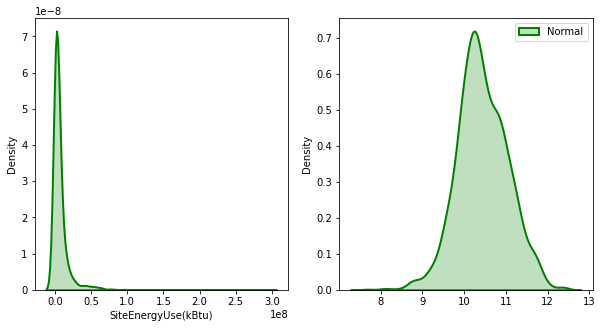

Lambda value used for Transformation: -0.05063349852267184


In [203]:
fitted_data, fitted_lambda = box_cot(df_energy['SiteEnergyUse(kBtu)'])

In [204]:
df_energy['energy_box_cox'] = fitted_data

In [205]:
# drop energystar score for my primary approch
df_energy_full = df_energy.copy()
df_energy = df_energy.drop(columns=['ENERGYSTARScore'])

## prepare X and y

In [206]:
X = df_energy.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y = df_energy['SiteEnergyUse(kBtu)']
y_boxcox = df_energy['energy_box_cox']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
X_train_box, X_test_box, y_train_box, y_test_box = train_test_split(X, y_boxcox, random_state=0)


## Baseline

In [14]:
dummy_regr_median = DummyRegressor(strategy="median")

dummy_regr_median.fit(X_train, y_train)
y_predict_dummy_median = dummy_regr_median.predict(X_test)
print(f'mae : {median_absolute_error(y_test,y_predict_dummy_median)}')
print(f'rmse : {mean_squared_error(y_test,y_predict_dummy_median)**0.5}')
print(f'r2 : {r2_score(y_test,y_predict_dummy_median)}')
print(f'mdape : {calcul_mdape(y_test,y_predict_dummy_median)}')

mae : 1802401.921875
rmse : 17310936.483940322
r2 : -0.06373775992852315
mdape : 72.8219969235453


In [15]:
scores_baseline_energie= {'time': 0.00, 
                          'MAE': -median_absolute_error(y_test,y_predict_dummy_median),
                          'RMSE': -mean_squared_error(y_test,y_predict_dummy_median)**0.5,
                          'r2': r2_score(y_test,y_predict_dummy_median)}

In [16]:
dummy_regr_median = DummyRegressor(strategy="median")

dummy_regr_median.fit(X_train_box, y_train_box)
y_predict_dummy_median = dummy_regr_median.predict(X_test_box)
print(f'mae : {median_absolute_error(y_test_box,y_predict_dummy_median)}')
print(f'rmse : {mean_squared_error(y_test_box,y_predict_dummy_median)**0.5}')
print(f'r2 : {r2_score(y_test_box,y_predict_dummy_median)}')
print(f'mdape : {calcul_mdape(y_test_box,y_predict_dummy_median)}')

scores_baseline_energie_box= {'time': 0.00, 
                          'MAE': -median_absolute_error(y_test_box,y_predict_dummy_median),
                          'RMSE': -mean_squared_error(y_test_box,y_predict_dummy_median)**0.5,
                          'r2': r2_score(y_test_box,y_predict_dummy_median)}

mae : 0.4180824225600004
rmse : 0.6238860563422458
r2 : -0.012710730594447162
mdape : 4.08953082001511


## First models

In [17]:
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

### Linear regression

<AxesSubplot:>

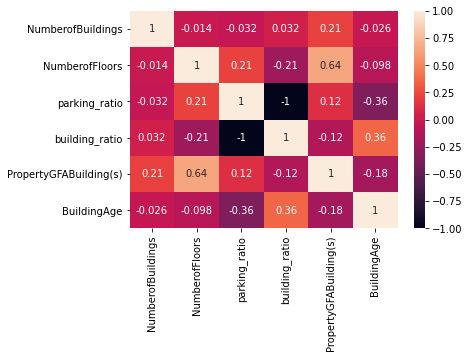

In [18]:
sns.heatmap(X[['NumberofBuildings',
 'NumberofFloors',
 'parking_ratio',
 'building_ratio',
 'PropertyGFABuilding(s)',
 'BuildingAge']].corr(), annot=True)

In [19]:
X_lin = X.drop(columns=['parking_ratio', 'building_ratio', 'NumberofFloors',  'PrimaryPropertyType_Retail Store'])

<AxesSubplot:>

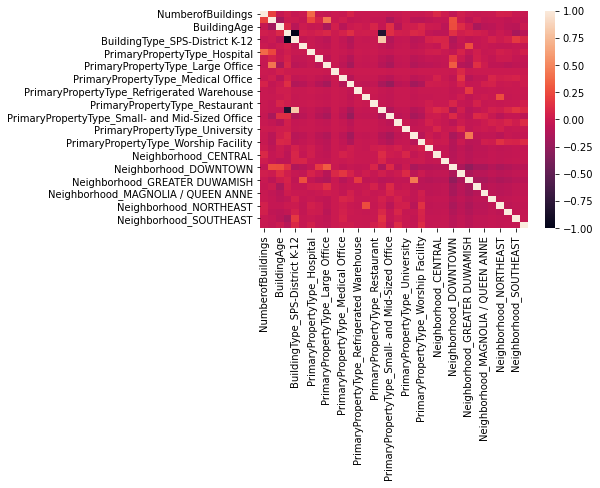

In [20]:
sns.heatmap(X_lin.corr())

In [21]:
from sklearn.linear_model import LinearRegression
model = 'linear regression'

lr = LinearRegression()
lr_scores = training(lr, X_lin, y)

print(f"score {model} : {lr_scores['time']}")
print(f"MAE {model} : {lr_scores['MAE']}")
print(f"RMSE {model} : {lr_scores['RMSE']}")
print(f"r2 {model} : {lr_scores['r2']}")

score linear regression : 0.01
MAE linear regression : -4303076.55
RMSE linear regression : -10000992.5
r2 linear regression : 0.38


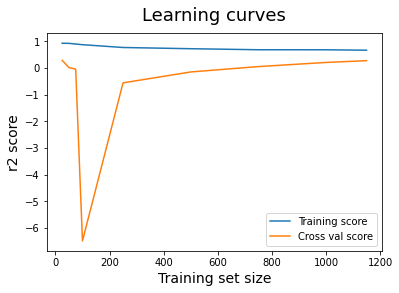

In [22]:
train_sizes = [25,50,75,100,250,500,750,1000,1150]
learning_curves(lr, X_lin,y,train_sizes)

In [23]:
# Le modele n'a pas l'air d'overfitter mais je vais essayer un lasso /Ridge 
#pour voir si je peux augmenter les performances

In [24]:
#with target boxcox
lr = LinearRegression()
lr_scores_boxcox = training(lr, X_lin, y_boxcox)

print(f"score {model} : {lr_scores_boxcox['time']}")
print(f"MAE {model} : {lr_scores_boxcox['MAE']}")
print(f"RMSE {model} : {lr_scores_boxcox['RMSE']}")
print(f"r2 {model} : {lr_scores_boxcox['r2']}")

score linear regression : 0.01
MAE linear regression : -0.34
RMSE linear regression : -0.45
r2 linear regression : 0.24


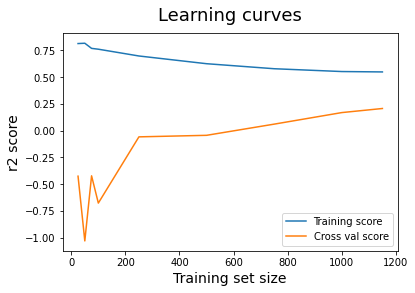

In [25]:
train_sizes = [25,50,75,100,250,500,750,1000,1150]
learning_curves(lr, X_lin,y_boxcox,train_sizes)

### Ridge

In [26]:
from sklearn.linear_model import Ridge
model = Ridge()
grid = {'alpha': np.linspace(-1, 10, 30)}

best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
                      
print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -4267585.536636412,
 best_params : {'alpha': -0.6206896551724138},
 best_estimator : Ridge(alpha=-0.6206896551724138)


In [27]:
model = Ridge(alpha=10)
ridge_scores = training(model, X, y)

print(f"score {model} : {ridge_scores['time']}")
print(f"MAE {model} : {ridge_scores['MAE']}")
print(f"RMSE {model} : {ridge_scores['RMSE']}")
print(f"r2 {model} : {ridge_scores['r2']}")

score Ridge(alpha=10) : 0.0
MAE Ridge(alpha=10) : -4374390.06
RMSE Ridge(alpha=10) : -10746437.88
r2 Ridge(alpha=10) : 0.3


In [28]:
#target boxcox
model = Ridge(alpha=10)
ridge_scores_box = training(model, X, y_boxcox)

print(f"score {model} : {ridge_scores_box['time']}")
print(f"MAE {model} : {ridge_scores_box['MAE']}")
print(f"RMSE {model} : {ridge_scores_box['RMSE']}")
print(f"r2 {model} : {ridge_scores_box['r2']}")

score Ridge(alpha=10) : 0.0
MAE Ridge(alpha=10) : -0.34
RMSE Ridge(alpha=10) : -0.44
r2 Ridge(alpha=10) : 0.26


### Lasso

In [29]:
from sklearn.linear_model import Lasso
model = Lasso()
grid = {'alpha': np.linspace(-1, 10, 30)}

best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
                      
print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -4275542.2783911545,
 best_params : {'alpha': 10.0},
 best_estimator : Lasso(alpha=10.0)


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.310e+16, tolerance: 5.353e+13
  model = cd_fast.enet_coordinate_descent(


In [30]:
model = Lasso(alpha=10)
lasso_scores = training(model, X, y)

print(f"score {model} : {lasso_scores['time']}")
print(f"MAE {model} : {lasso_scores['MAE']}")
print(f"RMSE {model} : {lasso_scores['RMSE']}")
print(f"r2 {model} : {lasso_scores['r2']}")

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.390e+16, tolerance: 2.677e+13
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+16, tolerance: 3.388e+13
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

score Lasso(alpha=10) : 0.07
MAE Lasso(alpha=10) : -4275542.28
RMSE Lasso(alpha=10) : -10029073.05
r2 Lasso(alpha=10) : 0.38


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.517e+16, tolerance: 5.049e+13
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e+16, tolerance: 4.978e+13
  model = cd_fast.enet_coordinate_descent(


In [31]:
#target boxcox
model = Lasso(alpha=10)
lasso_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {lasso_scores_boxcox['time']}")
print(f"MAE {model} : {lasso_scores_boxcox['MAE']}")
print(f"RMSE {model} : {lasso_scores_boxcox['RMSE']}")
print(f"r2 {model} : {lasso_scores_boxcox['r2']}")

score Lasso(alpha=10) : 0.0
MAE Lasso(alpha=10) : -0.52
RMSE Lasso(alpha=10) : -0.64
r2 Lasso(alpha=10) : -0.6


### KNN

In [32]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
grid = {'n_neighbors': np.arange(5,30)}

best_score,best_params,best_estimator = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
                      
print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -4341534.668605996,
 best_params : {'n_neighbors': 16},
 best_estimator : KNeighborsRegressor(n_neighbors=16)


In [33]:
model = KNeighborsRegressor(n_neighbors=5)
knn_scores = training(model, X, y)

print(f"score {model} : {knn_scores['time']}")
print(f"MAE {model} : {knn_scores['MAE']}")
print(f"RMSE {model} : {knn_scores['RMSE']}")
print(f"r2 {model} : {knn_scores['r2']}")

score KNeighborsRegressor() : 0.0
MAE KNeighborsRegressor() : -4573803.96
RMSE KNeighborsRegressor() : -12025789.21
r2 KNeighborsRegressor() : 0.06


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:4

In [34]:
#target boxcox
model = KNeighborsRegressor(n_neighbors=5)
knn_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {knn_scores_boxcox['time']}")
print(f"MAE {model} : {knn_scores_boxcox['MAE']}")
print(f"RMSE {model} : {knn_scores_boxcox['RMSE']}")
print(f"r2 {model} : {knn_scores_boxcox['r2']}")

score KNeighborsRegressor() : 0.0
MAE KNeighborsRegressor() : -0.32
RMSE KNeighborsRegressor() : -0.43
r2 KNeighborsRegressor() : 0.3


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:4

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
grid = {'n_estimators': [50,100, 200, 300, 500], 
        'min_samples_split':[2, 5, 10],
       'min_samples_leaf':[1, 2, 4],
       'max_depth':[10, 20, 30, 40]}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

In [36]:
model = RandomForestRegressor(
    n_estimators= 100,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=2,)
randomforest_scores = training(model, X, y)

print(f"score {model} : {randomforest_scores['time']}")
print(f"MAE {model} : {randomforest_scores['MAE']}")
print(f"RMSE {model} : {randomforest_scores['RMSE']}")
print(f"r2 {model} : {randomforest_scores['r2']}")

score RandomForestRegressor(max_depth=20, min_samples_leaf=2) : 0.36
MAE RandomForestRegressor(max_depth=20, min_samples_leaf=2) : -3863079.57
RMSE RandomForestRegressor(max_depth=20, min_samples_leaf=2) : -10242799.67
r2 RandomForestRegressor(max_depth=20, min_samples_leaf=2) : 0.48


In [37]:
#boxcox
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
grid = {'n_estimators': [50,100, 200, 300, 500], 
        'min_samples_split':[2, 5, 10],
       'min_samples_leaf':[1, 2, 4],
       'max_depth':[10, 20, 30, 40]}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y_boxcox)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')


In [38]:
model = RandomForestRegressor(
n_estimators= 500,
    max_depth=40,
    min_samples_split=10,
    min_samples_leaf=1,)
randomforest_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {randomforest_scores_boxcox['time']}")
print(f"MAE {model} : {randomforest_scores_boxcox['MAE']}")
print(f"RMSE {model} : {randomforest_scores_boxcox['RMSE']}")
print(f"r2 {model} : {randomforest_scores_boxcox['r2']}")

score RandomForestRegressor(max_depth=40, min_samples_split=10, n_estimators=500) : 1.56
MAE RandomForestRegressor(max_depth=40, min_samples_split=10, n_estimators=500) : -0.25
RMSE RandomForestRegressor(max_depth=40, min_samples_split=10, n_estimators=500) : -0.35
r2 RandomForestRegressor(max_depth=40, min_samples_split=10, n_estimators=500) : 0.52


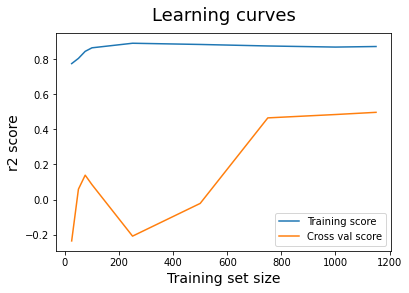

In [39]:
learning_curves(model, X, y_boxcox, train_sizes)

### XGBOOST

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
grid = {'n_estimators': [50,100, 200, 300, 500], 
        'min_samples_split':[2, 5, 10],
       'min_samples_leaf':[1, 2, 4]}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

In [41]:
model = GradientBoostingRegressor(
    n_estimators= 100,
    min_samples_split=2,
    min_samples_leaf=2,)
XGBOST_scores = training(model, X, y)

print(f"score {model} : {XGBOST_scores['time']}")
print(f"MAE {model} : {XGBOST_scores['MAE']}")
print(f"RMSE {model} : {XGBOST_scores['RMSE']}")
print(f"r2 {model} : {XGBOST_scores['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2) : 0.11
MAE GradientBoostingRegressor(min_samples_leaf=2) : -3890631.25
RMSE GradientBoostingRegressor(min_samples_leaf=2) : -10441837.08
r2 GradientBoostingRegressor(min_samples_leaf=2) : 0.37


In [42]:
#target boxcox
model = GradientBoostingRegressor(
    n_estimators= 180,
    min_samples_split=2,
    min_samples_leaf=2,)
XGBOST_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {XGBOST_scores_boxcox['time']}")
print(f"MAE {model} : {XGBOST_scores_boxcox['MAE']}")
print(f"RMSE {model} : {XGBOST_scores_boxcox['RMSE']}")
print(f"r2 {model} : {XGBOST_scores_boxcox['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.19
MAE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.25
RMSE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.35
r2 GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.52


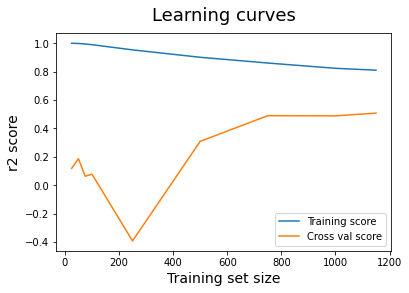

In [43]:
learning_curves(model, X, y_boxcox, train_sizes)

### Analyse

In [44]:
lr_scores

{'time': 0.01, 'MAE': -4303076.55, 'RMSE': -10000992.5, 'r2': 0.38}

In [45]:
scores = pd.DataFrame([
    scores_baseline_energie,
    lr_scores,
         ridge_scores,
         knn_scores,
         randomforest_scores, 
        XGBOST_scores], index=['baseline', 'lr', 'ridge', 'knn', 'randomforest', 'XGBOOST'])
scores['MAE']=scores['MAE']*-1
scores['RMSE']=scores['RMSE']*-1
scores

,time,MAE,RMSE,r2
baseline,0.00,1.802402e+06,1.731094e+07,-0.063738
lr,0.01,4.303077e+06,1.000099e+07,0.380000
ridge,0.00,4.374390e+06,1.074644e+07,0.300000
knn,0.00,4.573804e+06,1.202579e+07,0.060000
randomforest,0.36,3.863080e+06,1.024280e+07,0.480000
XGBOOST,0.11,3.890631e+06,1.044184e+07,0.370000


In [46]:
scores_baseline_energie_box

{'time': 0.0,
 'MAE': -0.4180824225600004,
 'RMSE': -0.6238860563422458,
 'r2': -0.012710730594447162}

In [47]:
scores_box = pd.DataFrame([
    scores_baseline_energie_box,
    lr_scores_boxcox,
         ridge_scores_box,
         knn_scores_boxcox,
         randomforest_scores_boxcox, 
        XGBOST_scores_boxcox], index=['baseline', 'lr', 'ridge', 'knn', 'randomforest', 'XGBOOST'])
scores_box['MAE']=scores_box['MAE']*-1
scores_box['RMSE']=scores_box['RMSE']*-1
scores_box

,time,MAE,RMSE,r2
baseline,0.00,0.418082,0.623886,-0.012711
lr,0.01,0.340000,0.450000,0.240000
ridge,0.00,0.340000,0.440000,0.260000
knn,0.00,0.320000,0.430000,0.300000
randomforest,1.56,0.250000,0.350000,0.520000
XGBOOST,0.19,0.250000,0.350000,0.520000


Text(0.5, 1.0, 'MAE')

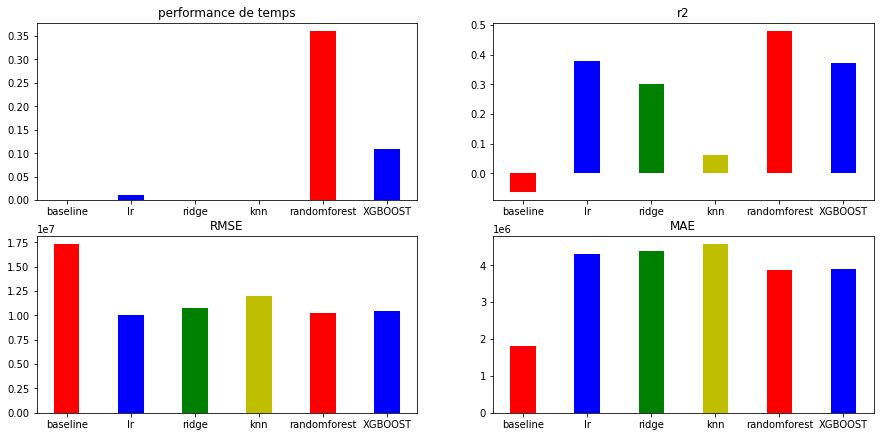

In [48]:
#Comparaison :
plt.figure(figsize=(15,15))
plt.subplot(421)
plt.bar(x=scores.index, height=list(scores['time']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('performance de temps')
plt.subplot(422)
plt.bar(x=scores.index, height=list(scores['r2']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('r2')
plt.subplot(423)
plt.bar(x=scores.index, height=list(scores['RMSE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('RMSE')
plt.subplot(424)
plt.bar(x=scores.index, height=list(scores['MAE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('MAE')

Text(0.5, 1.0, 'MAE boxcox')

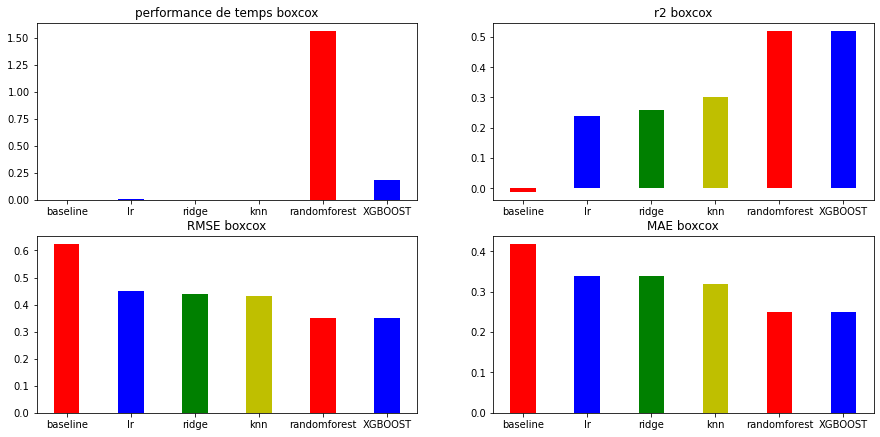

In [49]:
#Comparaison :
plt.figure(figsize=(15,15))
plt.subplot(421)
plt.bar(x=scores_box.index, height=list(scores_box['time']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('performance de temps boxcox')
plt.subplot(422)
plt.bar(x=scores_box.index, height=list(scores_box['r2']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('r2 boxcox')
plt.subplot(423)
plt.bar(x=scores_box.index, height=list(scores_box['RMSE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('RMSE boxcox')
plt.subplot(424)
plt.bar(x=scores_box.index, height=list(scores_box['MAE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('MAE boxcox')

On constate que le modele random forest et XGBOOST sont les deux modeles qui dominent

## Entrainement Random Forest

In [50]:
model = RandomForestRegressor(
    n_estimators= 140,
    min_samples_split=2,
    min_samples_leaf=1)
#fit
model.fit(X_train, y_train)
#pred
prediction = model.predict(X_test)
#features importances
model.feature_importances_.reshape(1,-1).shape

(1, 38)

In [51]:
#boxcox
model_box = RandomForestRegressor(
    n_estimators= 140,
    min_samples_split=2,
    min_samples_leaf=1)
#fit
model_box.fit(X_train_box, y_train_box)
#pred
prediction_box = model_box.predict(X_test_box)
#features importances
model_box.feature_importances_.reshape(1,-1).shape

(1, 38)

## Analyse

Text(0.5, 1.0, 'features importances sans boxcox')

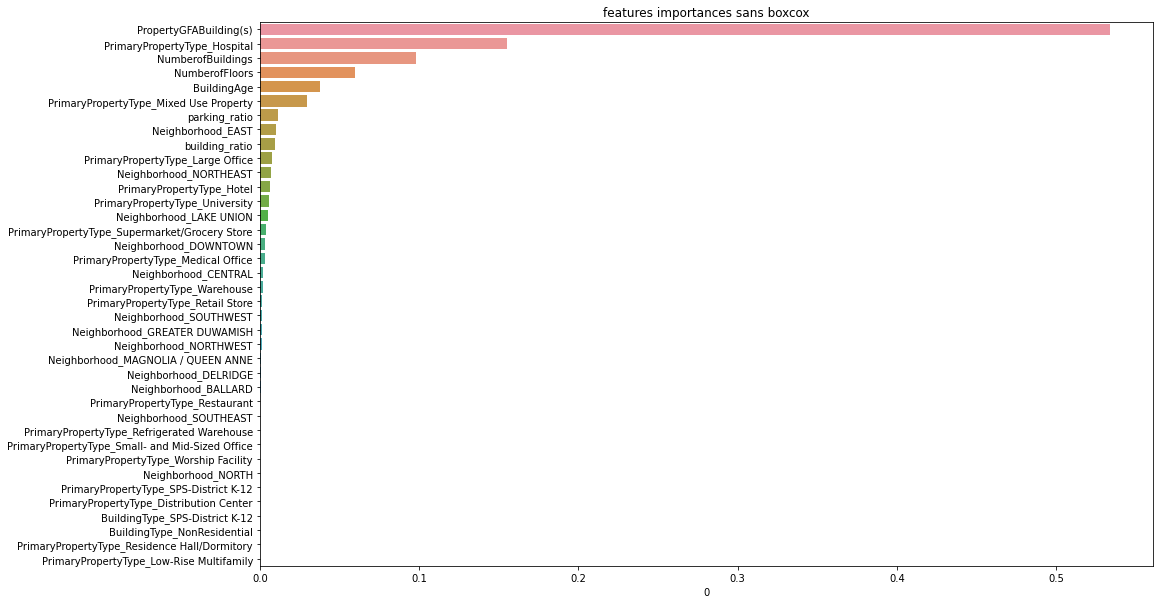

In [52]:
plt.figure(figsize=(16,10))
features = pd.DataFrame(model.feature_importances_.reshape(1,-1), columns=X_train.columns)
features=features.T
features=features.sort_values(by=0, ascending=False)
sns.barplot(x=features[0], y=list(features.index))
plt.title('features importances sans boxcox')

Text(0.5, 1.0, 'features importances avec boxcox')

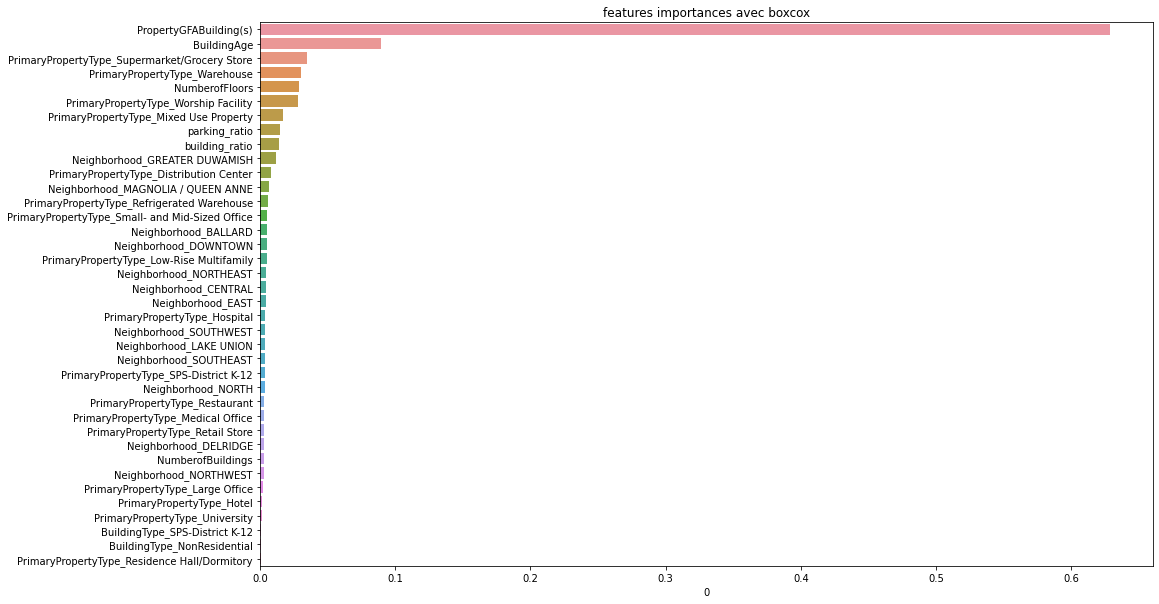

In [53]:
plt.figure(figsize=(16,10))
features = pd.DataFrame(model_box.feature_importances_.reshape(1,-1), columns=X_train_box.columns)
features=features.T
features=features.sort_values(by=0, ascending=False)
sns.barplot(x=features[0], y=list(features.index))
plt.title('features importances avec boxcox')

In [54]:
'''df_test=pd.concat([X_test, y_test], axis=1)
df_test.reset_index(drop=True, inplace=True)
df_test=pd.concat([df_test, y_test_box], axis=1)
df_test.reset_index(drop=True, inplace=True)
df_test=pd.concat([df_test, predictions], axis=1, )'''

'df_test=pd.concat([X_test, y_test], axis=1)\ndf_test.reset_index(drop=True, inplace=True)\ndf_test=pd.concat([df_test, y_test_box], axis=1)\ndf_test.reset_index(drop=True, inplace=True)\ndf_test=pd.concat([df_test, predictions], axis=1, )'

In [55]:
y_test=y_test.reset_index(drop=True)

In [56]:
predictions = pd.DataFrame({'pred': prediction, 'pred_box': prediction_box})

predictions.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test=y_test.reset_index(drop=True)
y_test_box=y_test_box.reset_index(drop=True)

df_test=pd.concat([predictions, X_test, y_test,y_test_box], axis=1)

In [57]:
df_test.isnull().sum()

pred                                               0
pred_box                                           0
NumberofBuildings                                  0
NumberofFloors                                     0
PropertyGFABuilding(s)                             0
parking_ratio                                      0
building_ratio                                     0
BuildingAge                                        0
BuildingType_NonResidential                        0
BuildingType_SPS-District K-12                     0
PrimaryPropertyType_Distribution Center            0
PrimaryPropertyType_Hospital                       0
PrimaryPropertyType_Hotel                          0
PrimaryPropertyType_Large Office                   0
PrimaryPropertyType_Low-Rise Multifamily           0
PrimaryPropertyType_Medical Office                 0
PrimaryPropertyType_Mixed Use Property             0
PrimaryPropertyType_Refrigerated Warehouse         0
PrimaryPropertyType_Residence Hall/Dormitory  

In [58]:
df_test['pred_box']=df_test['pred_box'].apply(lambda x : inv_boxcox(x, fitted_lambda))

In [59]:
median_absolute_error(list(df_test['SiteEnergyUse(kBtu)']), df_test['pred_box'])

3239530.1054987046

In [60]:
df_test['diff_pred_truth']=abs(df_test['SiteEnergyUse(kBtu)']-df_test['pred'])
df_test['diff_pred_truth_box']=abs(df_test['SiteEnergyUse(kBtu)']-df_test['pred_box'])

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


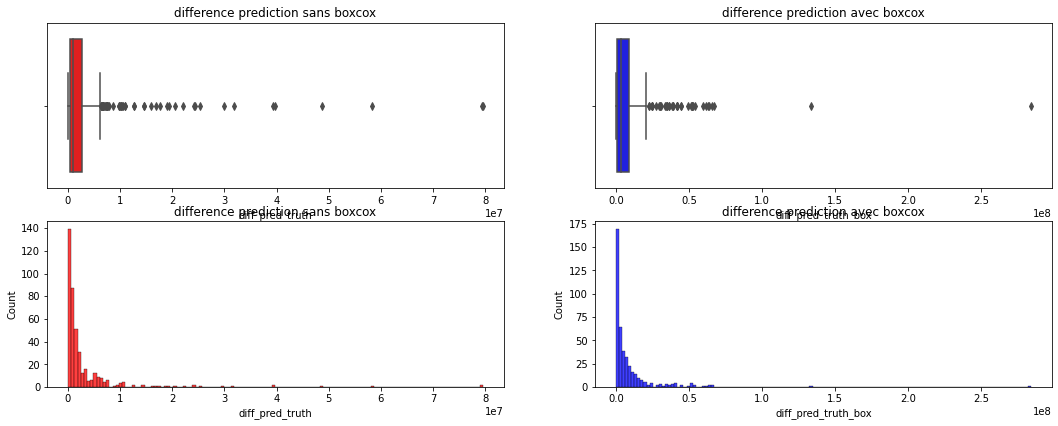

In [61]:
plt.figure(figsize=(18,14))
plt.subplot(421)
sns.boxplot(df_test['diff_pred_truth'], color='r')
plt.title('difference prediction sans boxcox')
plt.subplot(422)
sns.boxplot(df_test['diff_pred_truth_box'], color='b')
plt.title('difference prediction avec boxcox')
plt.subplot(423)
sns.histplot(df_test['diff_pred_truth'], color='r')
plt.title('difference prediction sans boxcox')
plt.subplot(424)
sns.histplot(df_test['diff_pred_truth_box'], color='b')
plt.title('difference prediction avec boxcox');

In [62]:
df_test['diff_pred_truth_box'].median()/df_test['SiteEnergyUse(kBtu)'].median()

1.3720516348478944

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)'>

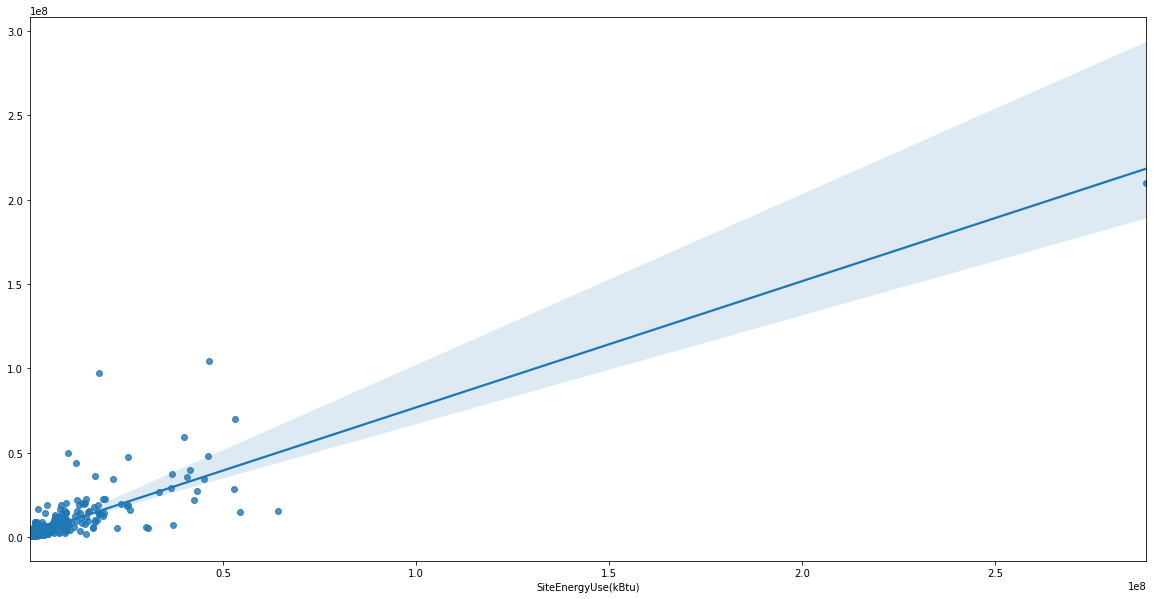

In [63]:
plt.figure(figsize=(20,10))
sns.regplot(y_test, prediction)

In [64]:
df_test[df_test['diff_pred_truth_box']==df_test['diff_pred_truth_box'].max()]

,pred,pred_box,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),parking_ratio,building_ratio,BuildingAge,BuildingType_NonResidential,BuildingType_SPS-District K-12,...,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,SiteEnergyUse(kBtu),energy_box_cox,diff_pred_truth,diff_pred_truth_box
376,2.095480e+08,5.060323e+06,4.046939,5.395918,35.508272,0.0,0.0,-0.663058,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,289149984.0,10.865917,7.960203e+07,2.840897e+08


In [65]:
df_test['SiteEnergyUse(kBtu)'].mean()

6785003.570370143

## Test améliorations 

### : remove columns with low interest

In [66]:
# Drop features peu impactantes
df_energy_features = df_energy.drop(columns=list(features.index[:28]))

In [67]:
X_features = df_energy_features.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y_features = df_energy_features['SiteEnergyUse(kBtu)']


In [68]:
model = RandomForestRegressor()
res = cross_validate(model, X_features, y_features, cv = 5, scoring=scoring)

randomforest_scores_f = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")

score RandomForestRegressor() : 0.08
MAE RandomForestRegressor() : -7032333.2
RMSE RandomForestRegressor() : -15253144.08
r2 RandomForestRegressor() : -0.45


In [69]:
randomforest_scores_f

{'time': 0.08, 'MAE': -7032333.2, 'RMSE': -15253144.08, 'r2': -0.45}

In [70]:
# Clairement nul !

### Remove outliers

In [71]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.15)
    q3 = df_in[col_name].quantile(0.85)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [72]:
df_energy_without_outliers = remove_outlier(df_energy, 'SiteEnergyUse(kBtu)')
len(df_energy_without_outliers)/len(df_energy)

0.9502696225284601

In [73]:
X_outliers = df_energy_without_outliers.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y_outliers = df_energy_without_outliers['SiteEnergyUse(kBtu)']
y_outliers_box=df_energy_without_outliers['energy_box_cox']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_outliers, y_outliers )
randomforest_scores_f_box = training(model_box, X_outliers, y_outliers_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_f_box['time']}")
print(f"MAE {model} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.41
MAE RandomForestRegressor() : -1973998.98
RMSE RandomForestRegressor() : -3082121.25
r2 RandomForestRegressor() : 0.5
______
score RandomForestRegressor() : 0.39
MAE RandomForestRegressor() : -0.25
RMSE RandomForestRegressor() : -0.36
r2 RandomForestRegressor() : 0.43


<AxesSubplot:xlabel='energy_box_cox', ylabel='Count'>

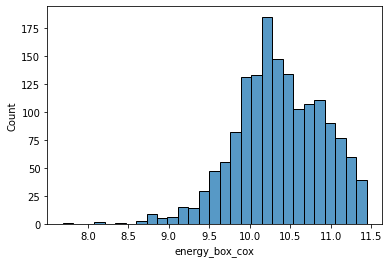

In [74]:
sns.histplot(y_outliers_box)

In [75]:
# Permet d'obternir les meilleurs résultats sans gridsearch !

## EnergyStarScore impact?

In [76]:
df_energy_full.isnull().sum()

NumberofBuildings                                    0
NumberofFloors                                       0
PropertyGFABuilding(s)                               0
ENERGYSTARScore                                    523
SiteEnergyUse(kBtu)                                  0
TotalGHGEmissions                                    0
parking_ratio                                        0
building_ratio                                       0
BuildingAge                                          0
BuildingType_NonResidential                          0
BuildingType_SPS-District K-12                       0
PrimaryPropertyType_Distribution Center              0
PrimaryPropertyType_Hospital                         0
PrimaryPropertyType_Hotel                            0
PrimaryPropertyType_Large Office                     0
PrimaryPropertyType_Low-Rise Multifamily             0
PrimaryPropertyType_Medical Office                   0
PrimaryPropertyType_Mixed Use Property               0
PrimaryPro

In [77]:
df_energy_full_=df_energy_full[~df_energy_full['ENERGYSTARScore'].isna()]
X_stars = df_energy_full_.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y_stars = df_energy_full_['SiteEnergyUse(kBtu)']
y_stars_box = df_energy_full_['energy_box_cox']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_stars, y_stars )
randomforest_scores_f_box = training(model_box, X_stars, y_stars_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_f_box['time']}")
print(f"MAE {model} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.35
MAE RandomForestRegressor() : -3620059.41
RMSE RandomForestRegressor() : -12467529.88
r2 RandomForestRegressor() : 0.4
______
score RandomForestRegressor() : 0.32
MAE RandomForestRegressor() : -0.17
RMSE RandomForestRegressor() : -0.25
r2 RandomForestRegressor() : 0.74


In [78]:
adjusted_r_squarred(randomforest_scores_f['r2'], X_stars, y_stars)

0.37884267631103075

In [79]:
adjusted_r_squarred(randomforest_scores_f_box['r2'], X_stars, y_stars_box)

0.7308318264014466

In [80]:
X_without_stars = df_energy_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'ENERGYSTARScore','energy_box_cox' ])
y_without_stars = df_energy_full['SiteEnergyUse(kBtu)']
y_without_stars_box = df_energy_full['energy_box_cox']


model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_without_stars, y_without_stars )
randomforest_scores_f_box = training(model_box, X_without_stars, y_without_stars_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_f_box['time']}")
print(f"MAE {model} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.32
MAE RandomForestRegressor() : -4002509.9
RMSE RandomForestRegressor() : -12501646.83
r2 RandomForestRegressor() : 0.48
______
score RandomForestRegressor() : 0.29
MAE RandomForestRegressor() : -0.22
RMSE RandomForestRegressor() : -0.32
r2 RandomForestRegressor() : 0.59


In [81]:
adjusted_r_squarred(randomforest_scores_f['r2'], X_without_stars, y_without_stars)

0.4621499548328817

In [82]:
adjusted_r_squarred(randomforest_scores_f_box['r2'], X_without_stars, y_without_stars_box)

0.575925925925926

In [83]:
#l'EnergieStarScore semble aveoir un impact APRES boxcox 🧐

## Methode avec KNN imputer

In [207]:
X_knn = df_energy_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
X_knn_without_star = df_energy_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox', 'ENERGYSTARScore'])
y_boxcox_knn = df_energy_full['energy_box_cox']

In [208]:
from sklearn.impute import KNNImputer

In [209]:
#fit on the dataset
imputer = KNNImputer(n_neighbors=5)
X_knn=imputer.fit_transform(X_knn)

# transform the dataset
#Xtrans = imputer.transform(X)

In [210]:
model = RandomForestRegressor()
randomforest_scores_star = training(model, X_knn, y_boxcox_knn)
model = RandomForestRegressor()
randomforest_scores_w_star = training(model_box, X_knn_without_star, y_boxcox_knn)

In [211]:
print(f"score {model} : {randomforest_scores_star['time']}")
print(f"MAE {model} : {randomforest_scores_star['MAE']}")
print(f"RMSE {model} : {randomforest_scores_star['RMSE']}")
print(f"r2 {model} : {randomforest_scores_star['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_w_star['time']}")
print(f"MAE {model} : {randomforest_scores_w_star['MAE']}")
print(f"RMSE {model} : {randomforest_scores_w_star['RMSE']}")
print(f"r2 {model} : {randomforest_scores_w_star['r2']}")

score RandomForestRegressor() : 0.48
MAE RandomForestRegressor() : -0.23
RMSE RandomForestRegressor() : -0.32
r2 RandomForestRegressor() : 0.6
______
score RandomForestRegressor() : 0.41
MAE RandomForestRegressor() : -0.26
RMSE RandomForestRegressor() : -0.36
r2 RandomForestRegressor() : 0.5


In [212]:
adjusted_r_squarred(randomforest_scores_star['r2'], X_knn, y_boxcox_knn)

0.5904235727440147

In [213]:
adjusted_r_squarred(randomforest_scores_w_star['r2'], X_knn, y_boxcox_knn)

0.4880294659300184

# Emission 

In [214]:
df_emission = df.copy(deep=True)

## Derniers ajustements

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

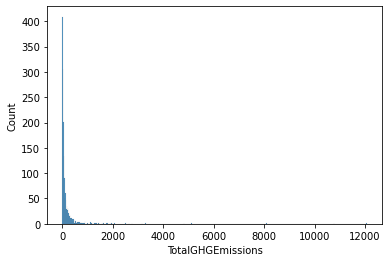

In [215]:
sns.histplot(df_emission['TotalGHGEmissions'])

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


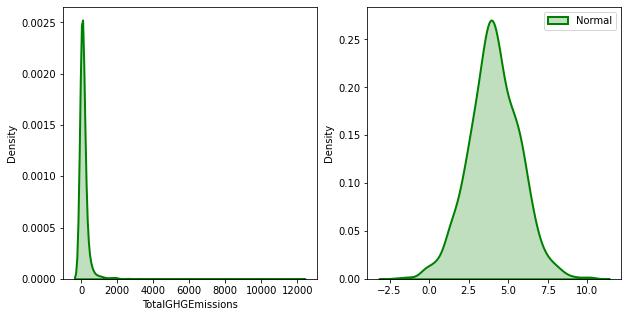

Lambda value used for Transformation: 0.01917816976224552


In [216]:
fitted_data, fitted_lambda = box_cot(df_emission['TotalGHGEmissions'])
df_emission['boxcox_emission']=fitted_data

<AxesSubplot:xlabel='boxcox_emission', ylabel='Count'>

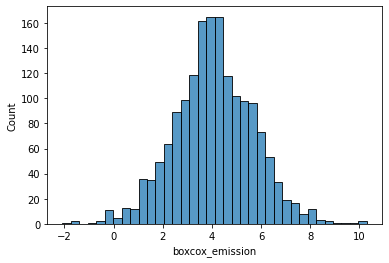

In [217]:
sns.histplot(df_emission['boxcox_emission'])

In [218]:
df_emission=df_emission.drop(columns=['Latitude', 'Longitude', 'OSEBuildingID'])

In [219]:
# drop energystar score for my primary approch
df_emission_full = df_emission.copy()
df_emission = df_emission_full.drop(columns=['ENERGYSTARScore'])

## Prepare X & y

In [94]:
X = df_emission.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission'])
y = df_emission['TotalGHGEmissions']
y_boxcox = df_emission['boxcox_emission']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_box, X_test_box, y_train_box, y_test_box = train_test_split(X, y_boxcox, random_state=0)

## Baseline

In [95]:
dummy_regr_median = DummyRegressor(strategy="median")

dummy_regr_median.fit(X_train, y_train)
y_predict_dummy_median = dummy_regr_median.predict(X_test)
print(f'mae : {median_absolute_error(y_test,y_predict_dummy_median)}')
print(f'rmse : {mean_squared_error(y_test,y_predict_dummy_median)**0.5}')
print(f'r2 : {r2_score(y_test,y_predict_dummy_median)}')
print(f'mdape : {calcul_mdape(y_test,y_predict_dummy_median)}')


mae : 39.135000000000005
rmse : 405.1517503942048
r2 : -0.08016391186436533
mdape : 78.9512243419167


In [96]:
y.median()

48.755

## models evaluation :

### Linear Reg

In [97]:
from sklearn.linear_model import LinearRegression
model = 'linear regression'

lr = LinearRegression()
lr_scores = training(lr, X, y)

print(f"score {model} : {lr_scores['time']}")
print(f"MAE {model} : {lr_scores['MAE']}")
print(f"RMSE {model} : {lr_scores['RMSE']}")
print(f"r2 {model} : {lr_scores['r2']}")

score linear regression : 0.01
MAE linear regression : -16967317056.38
RMSE linear regression : -296823730065.46
r2 linear regression : -3.3538626421060106e+18


In [98]:
from sklearn.linear_model import LinearRegression
model = 'linear regression'

lr = LinearRegression()
lr_scores_box = training(lr, X, y_boxcox)

print(f"score {model} : {lr_scores_box['time']}")
print(f"MAE {model} : {lr_scores_box['MAE']}")
print(f"RMSE {model} : {lr_scores_box['RMSE']}")
print(f"r2 {model} : {lr_scores_box['r2']}")

score linear regression : 0.01
MAE linear regression : -46426584.56
RMSE linear regression : -812179779.38
r2 linear regression : -1.3764798219541417e+18


### Random Forest

In [99]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
grid = {'n_estimators': [50,100, 200, 300, 500], 
        'min_samples_split':[2, 5, 10],
       'min_samples_leaf':[1, 2, 4],
       'max_depth':[10, 20, 30, 40]}

reboot =True #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -105.6340330324761,
 best_params : {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},
 best_estimator : RandomForestRegressor(max_depth=20, min_samples_leaf=2)


In [100]:
model = RandomForestRegressor(
n_estimators= 50,
    max_depth=40,
    min_samples_split=2,
    min_samples_leaf=2,)
randomforest_scores = training(model, X, y)

print(f"score {model} : {randomforest_scores['time']}")
print(f"MAE {model} : {randomforest_scores['MAE']}")
print(f"RMSE {model} : {randomforest_scores['RMSE']}")
print(f"r2 {model} : {randomforest_scores['r2']}")

score RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=50) : 0.2
MAE RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=50) : -109.43
RMSE RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=50) : -311.9
r2 RandomForestRegressor(max_depth=40, min_samples_leaf=2, n_estimators=50) : 0.4


In [101]:
model = RandomForestRegressor()
randomforest_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {randomforest_scores_boxcox['time']}")
print(f"MAE {model} : {randomforest_scores_boxcox['MAE']}")
print(f"RMSE {model} : {randomforest_scores_boxcox['RMSE']}")
print(f"r2 {model} : {randomforest_scores_boxcox['r2']}")

score RandomForestRegressor() : 0.43
MAE RandomForestRegressor() : -0.91
RMSE RandomForestRegressor() : -1.19
r2 RandomForestRegressor() : 0.32


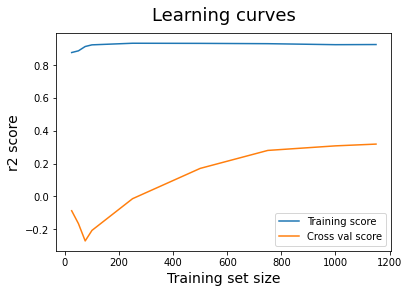

In [102]:
learning_curves(model, X, y_boxcox, train_sizes)

### XGBOOST

In [103]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
grid = {'n_estimators': [50,100, 200, 300, 500], 
        'min_samples_split':[2, 5, 10],
       'min_samples_leaf':[1, 2, 4]}

reboot =True #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -101.55904453149259,
 best_params : {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},
 best_estimator : GradientBoostingRegressor(min_samples_leaf=2)


In [104]:
model = GradientBoostingRegressor(
min_samples_leaf= 2,
min_samples_split=5,
n_estimators=5
)
XGBOST_scores = training(model, X, y)

print(f"score {model} : {XGBOST_scores['time']}")
print(f"MAE {model} : {XGBOST_scores['MAE']}")
print(f"RMSE {model} : {XGBOST_scores['RMSE']}")
print(f"r2 {model} : {XGBOST_scores['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=5,
                          n_estimators=5) : 0.01
MAE GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=5,
                          n_estimators=5) : -150.3
RMSE GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=5,
                          n_estimators=5) : -372.5
r2 GradientBoostingRegressor(min_samples_leaf=2, min_samples_split=5,
                          n_estimators=5) : 0.22


In [105]:
#target boxcox
model = GradientBoostingRegressor(
    n_estimators= 180,
    min_samples_split=2,
    min_samples_leaf=2,)
XGBOST_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {XGBOST_scores_boxcox['time']}")
print(f"MAE {model} : {XGBOST_scores_boxcox['MAE']}")
print(f"RMSE {model} : {XGBOST_scores_boxcox['RMSE']}")
print(f"r2 {model} : {XGBOST_scores_boxcox['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.2
MAE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.89
RMSE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -1.16
r2 GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.37


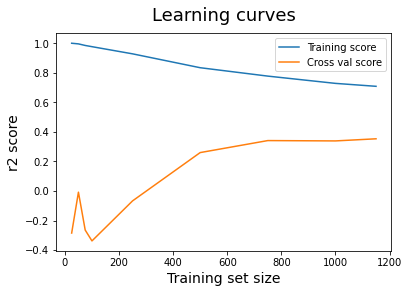

In [106]:
learning_curves(model, X, y_boxcox, train_sizes)

In [107]:
scores = pd.DataFrame([lr_scores,
         randomforest_scores, 
        XGBOST_scores], index=['lr','randomforest', 'XGBOOST'])
scores['MAE']=scores['MAE']*-1
scores['RMSE']=scores['RMSE']*-1
scores_box = pd.DataFrame([lr_scores_boxcox,
         randomforest_scores_boxcox, 
        XGBOST_scores_boxcox], index=['lr', 'randomforest', 'XGBOOST'])
scores_box['MAE']=scores_box['MAE']*-1
scores_box['RMSE']=scores_box['RMSE']*-1
scores_box

,time,MAE,RMSE,r2
lr,0.01,0.34,0.45,0.24
randomforest,0.43,0.91,1.19,0.32
XGBOOST,0.20,0.89,1.16,0.37


In [108]:
scores

,time,MAE,RMSE,r2
lr,0.01,1.696732e+10,2.968237e+11,-3.353863e+18
randomforest,0.20,1.094300e+02,3.119000e+02,4.000000e-01
XGBOOST,0.01,1.503000e+02,3.725000e+02,2.200000e-01


## EnergyStar

In [226]:
df_emission_full_=df_emission_full[~df_emission_full['ENERGYSTARScore'].isna()]
X_stars = df_emission_full_.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission'])
y_stars = df_emission_full_['TotalGHGEmissions']
y_stars_box = df_emission_full_['boxcox_emission']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_stars, y_stars )
randomforest_scores_f_box = training(model_box, X_stars, y_stars_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model_box} : {randomforest_scores_f_box['time']}")
print(f"MAE {model_box} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model_box} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model_box} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.38
MAE RandomForestRegressor() : -108.22
RMSE RandomForestRegressor() : -346.87
r2 RandomForestRegressor() : 0.48
______
score RandomForestRegressor() : 0.34
MAE RandomForestRegressor() : -0.79
RMSE RandomForestRegressor() : -1.0
r2 RandomForestRegressor() : 0.49


In [110]:
adjusted_r_squarred(randomforest_scores_f['r2'], X_stars, y_stars)

0.45131103074141043

In [111]:
adjusted_r_squarred(randomforest_scores_f_box['r2'], X_stars, y_stars_box)

0.46166365280289334

In [112]:
X_without_stars = df_emission_full_.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission', 'ENERGYSTARScore'])
y_without_stars = df_emission_full_['TotalGHGEmissions']
y_without_stars_box = df_emission_full_['boxcox_emission']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_without_stars, y_without_stars )
randomforest_scores_f_box = training(model_box, X_without_stars, y_without_stars_box)

print('WITHOUT ENERGYSTARSCORE')

print('not boxcox')
print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print('boxcox')
print(f"score {model_box} : {randomforest_scores_f_box['time']}")
print(f"MAE {model_box} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model_box} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model_box} : {randomforest_scores_f_box['r2']}")

WITHOUT ENERGYSTARSCORE
not boxcox
score RandomForestRegressor() : 0.34
MAE RandomForestRegressor() : -106.61
RMSE RandomForestRegressor() : -336.9
r2 RandomForestRegressor() : 0.49
______
boxcox
score RandomForestRegressor() : 0.3
MAE RandomForestRegressor() : -0.84
RMSE RandomForestRegressor() : -1.1
r2 RandomForestRegressor() : 0.38


In [113]:
adjusted_r_squarred(randomforest_scores_f['r2'], X_without_stars, y_without_stars)

0.4724932249322493

In [114]:
adjusted_r_squarred(randomforest_scores_f_box['r2'], X_without_stars, y_without_stars_box)

0.35871725383920505

In [115]:
# ENERGYSTARScore semble améliorer les perfs après boxcox

## KNN imputer

In [222]:
df_emission_full

,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,parking_ratio,building_ratio,BuildingAge,BuildingType_NonResidential,...,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,boxcox_emission
0,0.0,4.496598,0.856606,-0.335201,7.103895e+06,249.705,0.000000,0.000000,0.868834,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.823084
1,0.0,4.046939,0.858011,-0.547767,8.371084e+06,279.685,19.621331,-19.621331,-0.708786,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.949267
2,0.0,17.536734,16.808568,-1.381682,7.285884e+07,2075.380,13.877511,-13.877511,-0.091456,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.225647
3,0.0,3.597279,0.296531,-0.547767,6.794584e+06,286.430,0.000000,0.000000,0.891698,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.975822
4,0.0,7.194557,1.312511,-0.057229,1.450085e+07,506.355,30.827149,-30.827149,-0.342961,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.614344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,0.0,-0.449660,-0.716164,-0.874793,8.497457e+05,20.940,0.000000,0.000000,-0.571601,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.132127
1665,0.0,-0.449660,-0.639612,NaN,9.502762e+05,32.170,0.000000,0.000000,-0.891698,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.589171
1666,0.0,-0.449660,-0.698337,NaN,5.765898e+06,223.540,0.000000,0.000000,-0.205777,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.700163
1667,0.0,-0.449660,-0.678838,NaN,7.194712e+05,22.110,0.000000,0.000000,-0.548737,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.189792


In [230]:
X_knn = df_emission_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission'])
X_knn_without_star = df_emission_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission', 'ENERGYSTARScore'])
y_boxcox_knn = df_emission_full['boxcox_emission']

In [237]:
imputer = KNNImputer(n_neighbors=5)
X_knn=imputer.fit_transform(X_knn)

# transform the dataset
#Xtrans = imputer.transform(X)

In [238]:
model = RandomForestRegressor()
randomforest_scores_star = training(model, X_knn, y_boxcox_knn)
model = RandomForestRegressor()
randomforest_scores_w_star = training(model_box, X_knn_without_star, y_boxcox_knn)

In [239]:
print(f"score {model} : {randomforest_scores_star['time']}")
print(f"MAE {model} : {randomforest_scores_star['MAE']}")
print(f"RMSE {model} : {randomforest_scores_star['RMSE']}")
print(f"r2 {model} : {randomforest_scores_star['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_w_star['time']}")
print(f"MAE {model} : {randomforest_scores_w_star['MAE']}")
print(f"RMSE {model} : {randomforest_scores_w_star['RMSE']}")
print(f"r2 {model} : {randomforest_scores_w_star['r2']}")

score RandomForestRegressor() : 0.49
MAE RandomForestRegressor() : -0.87
RMSE RandomForestRegressor() : -1.12
r2 RandomForestRegressor() : 0.41
______
score RandomForestRegressor() : 0.42
MAE RandomForestRegressor() : -0.91
RMSE RandomForestRegressor() : -1.19
r2 RandomForestRegressor() : 0.33


# Last training

In [120]:
# remove outliers
# adding energiestarscores

In [240]:
df_without_outliers= df.drop(columns=['Latitude','Longitude', 'OSEBuildingID' ])

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


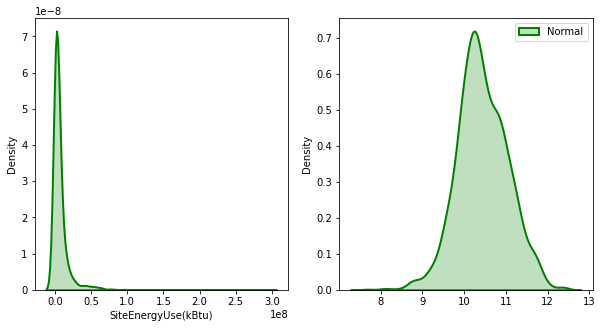

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Lambda value used for Transformation: -0.05063349852267184


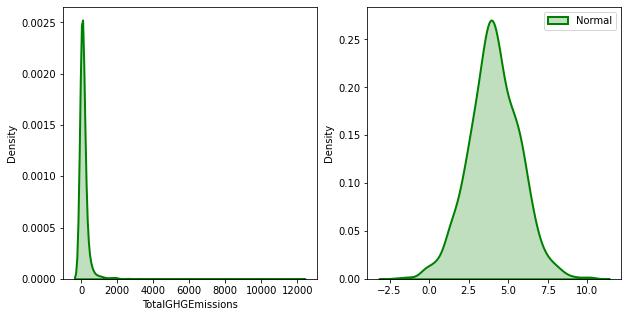

Lambda value used for Transformation: 0.01917816976224552


In [241]:
fitted_data_energie, fitted_lambda_energie = box_cot(df_without_outliers['SiteEnergyUse(kBtu)'])
fitted_data_emission, fitted_lambda_emission = box_cot(df_without_outliers['TotalGHGEmissions'])

In [242]:
df_without_outliers['emission_box']=fitted_data_emission
df_without_outliers['energie_box']=fitted_data_energie

In [243]:
df_without_outliers.describe()

,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,parking_ratio,building_ratio,BuildingAge,BuildingType_NonResidential,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,emission_box,energie_box
count,1669.000000,1669.000000,1669.000000,1146.000000,1.669000e+03,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,...,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000,1669.000000
mean,0.053345,0.960208,1.027607,-0.248765,7.328041e+06,159.087777,8.259692,-8.259691,0.075264,0.941881,...,0.206111,0.089874,0.089874,0.040144,0.075494,0.052127,0.028760,0.024566,4.080429,10.432877
std,0.444237,2.949961,3.324258,0.911915,1.791494e+07,541.740685,18.172764,18.172765,0.750375,0.234038,...,0.404633,0.286087,0.286087,0.196355,0.264266,0.222350,0.167181,0.154843,1.615966,0.605811
min,0.000000,-0.449660,-0.744442,-2.346407,1.697945e+04,0.120000,0.000000,-107.671150,-1.143203,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.077734,7.688690
25%,0.000000,-0.449660,-0.385457,-0.838002,1.230588e+06,19.825000,0.000000,0.000000,-0.548737,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.074153,10.040238
50%,0.000000,0.000000,0.000000,0.000000,2.512364e+06,48.755000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.035340,10.384863
75%,0.000000,0.899320,0.963523,0.510977,6.720859e+06,134.940000,0.000000,0.000000,0.800242,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.142925,10.840018
max,8.768367,43.617004,35.508272,0.891144,2.944517e+08,12066.025000,107.671150,0.001971,1.486164,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.298370,12.392000


In [249]:
#df_without_outliers=df_without_outliers[~df_without_outliers['ENERGYSTARScore'].isna()]
X=df_without_outliers.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'emission_box','energie_box' ])
X=imputer.fit_transform(X)
y_emission=df_without_outliers['emission_box']
y_energie=df_without_outliers['energie_box']

## Energie

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y_energie, random_state=0)

In [251]:
grid={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 600, 800]}
model = RandomForestRegressor()
tres_long=False
if tres_long :
    best_score,best_params,best_estimator =grid_search(model, grid, 'neg_mean_absolute_error', X, y_energie)
    print(best_score,best_params,best_estimator)

In [252]:
model = RandomForestRegressor(bootstrap=True,
                             max_depth=50,
                             max_features='auto',
                             n_estimators=100,
    min_samples_split=10
)
model.fit(X_train, y_train)
prediction_energie = model.predict(X_test)

In [253]:
prediction_invboxcox=[]
y_test_invboxcox=[]
for i in prediction_energie:
    prediction_invboxcox.append(inv_boxcox(i, fitted_lambda_energie))
for j in y_test:
    y_test_invboxcox.append(inv_boxcox(j, fitted_lambda_energie))

In [254]:
print(f'mae : {median_absolute_error(y_test_invboxcox,prediction_invboxcox)}')
print(f'rmse : {mean_squared_error(y_test_invboxcox,prediction_invboxcox)**0.5}')
print(f'mdape : {calcul_mdape(y_test_invboxcox, prediction_invboxcox)}')
print(f'r squarred : {r2_score(y_test_invboxcox, prediction_invboxcox)}')

mae : 907716.4494281255
rmse : 7730351.756934784
mdape : 30.559683453814735
r squarred : 0.7131846286096627


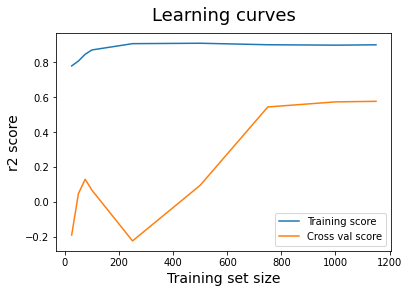

In [255]:
learning_curves(model, X, y_energie,train_size=train_sizes)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

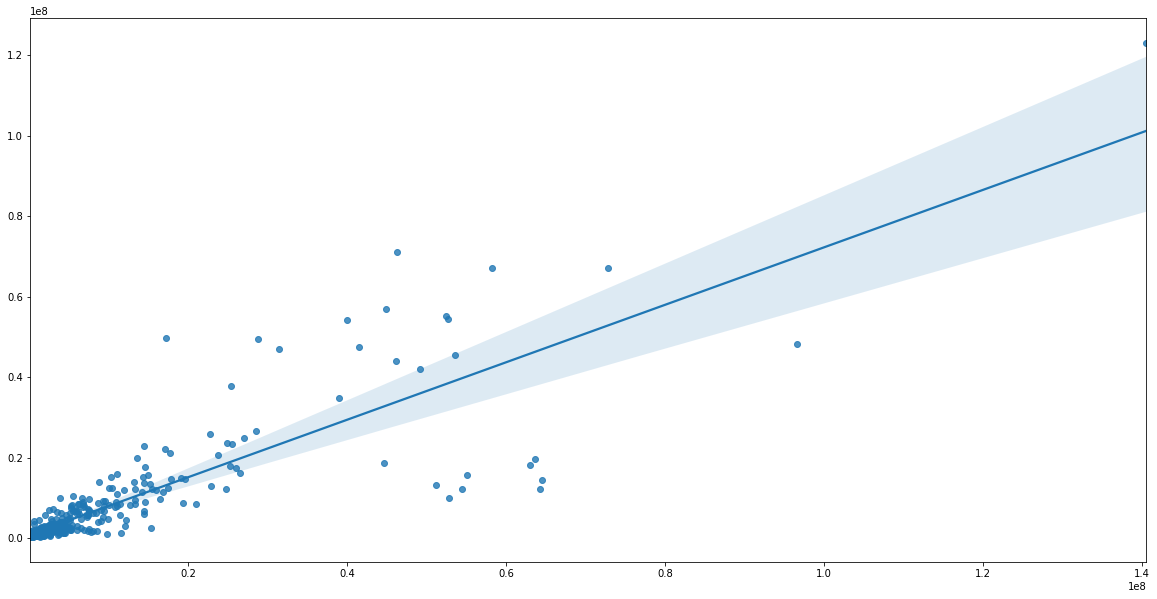

In [256]:
plt.figure(figsize=(20,10))
sns.regplot(y_test_invboxcox,prediction_invboxcox)

## Emission

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y_emission, random_state=0)

In [258]:
grid={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
model = RandomForestRegressor()
if tres_long :
    best_score,best_params,best_estimator =grid_search(model, grid, 'neg_mean_absolute_error', X, y_emission)
    print(best_score,best_params,best_estimator)

In [259]:
model = RandomForestRegressor(bootstrap=True,
                                max_depth=40,
                              max_features='auto',
                              min_samples_leaf=2,
                              min_samples_split=10,
                              n_estimators=1200
                             )
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=1200)

In [260]:
prediction_emission = model.predict(X_test)

prediction_invboxcox=[]
y_test_invboxcox=[]
for i in prediction_emission:
    prediction_invboxcox.append(inv_boxcox(i, fitted_lambda_emission))
for j in y_test:
    y_test_invboxcox.append(inv_boxcox(j, fitted_lambda_emission))
    
print(f'mae : {median_absolute_error(y_test_invboxcox,prediction_invboxcox)}')
print(f'rmse : {mean_squared_error(y_test_invboxcox,prediction_invboxcox)**0.5}')
print(f'mdape : {calcul_mdape(y_test_invboxcox, prediction_invboxcox)}')
print(f'r squarred : {r2_score(y_test_invboxcox, prediction_invboxcox)}')

mae : 26.08158933416001
rmse : 235.18767764512842
mdape : 56.02180888367075
r squarred : 0.6360151129412508


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

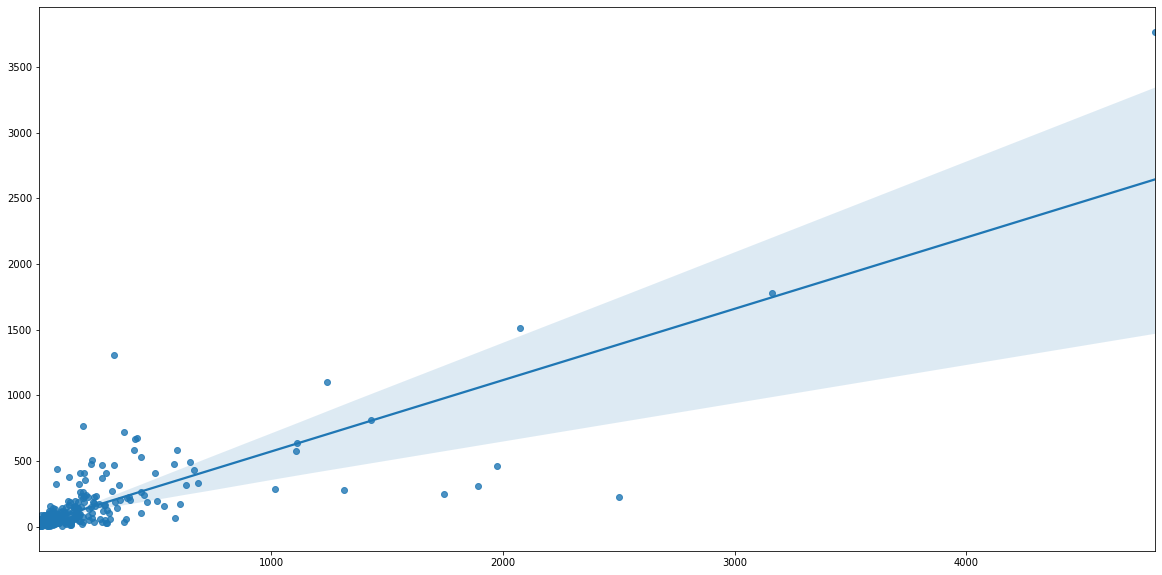

In [261]:
plt.figure(figsize=(20,10))
sns.regplot(y_test_invboxcox,prediction_invboxcox)

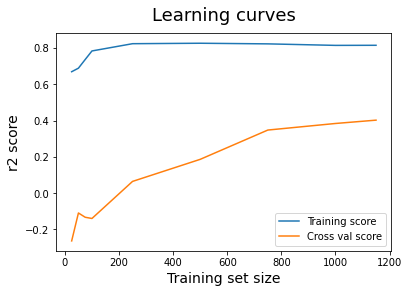

In [262]:
learning_curves(model, X,y_emission,train_size=train_sizes)